In [3]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt
import scipy.stats as stats

from data_processing import *

%load_ext autoreload
%autoreload 2


In [52]:
X, y = get_training_data()
X_testing = get_testing_data()
#Unnamed: 0 is the Id of the row, we can drop it
X = X.drop('Unnamed: 0', axis=1 )

x_testing_id = X_testing['Unnamed: 0']
X_testing = X_testing.drop('Unnamed: 0', axis=1 )
# Unnamed: 0 is the Id of the row, we can drop it
y = y.drop(columns=['Unnamed: 0'])  # If the first column is labeled as 'Unnamed: 0'


### Data exploration

In [ ]:
print('Number of elements :', len(X))
print('Number of features :', len(X.columns))

In [ ]:
print('len(y):', len(y))

In [ ]:
X.info()

In [ ]:
X.isnull().sum()

In [ ]:
unique_values = {}
for col in X.columns:
    unique_values[col] = X[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['unique value count']).transpose()

In [ ]:
plt.figure(figsize = (15,25))
for i,col in enumerate(['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age','Education', 'Income']):
    plt.subplot(4,2,i+1)
    plt.title('Distribution of '+col)
    plt.boxplot(x = col, data = X, vert=False)
plt.show()

In [ ]:
cols = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 
        'PhysActivity', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk']

def create_plot_pivot(data, x_column):
    """Create a pivot table for satisfaction versus another rating for easy plotting."""
    # Merge `X` and `y` to ensure access to 'Diabetes_binary' column for grouping
    data_with_target = data.copy()
    data_with_target['Diabetes_binary'] = y['Diabetes_binary']
    data_with_target['Diabetes_binary'] = data_with_target['Diabetes_binary'].replace({0: 'No Diabetes', 1: 'Diabetes'})
    
    _df_plot = data_with_target.groupby([x_column, 'Diabetes_binary']).size() \
                   .reset_index().pivot(columns='Diabetes_binary', index=x_column, values=0)
    return _df_plot

fig, ax = plt.subplots(3, 4, figsize=(20, 20))
axe = ax.ravel()
c = len(cols)
plt.suptitle('Diabetes Distribution by Features', fontsize=20)

# Custom colors for the plot
custom_colors = {'No Diabetes': 'green', 'Diabetes': 'red'}

# Plotting each column in cols
for i in range(c):
    plot_data = create_plot_pivot(X, cols[i])
    plot_data.plot(kind='bar', stacked=True, ax=axe[i], color=[custom_colors[val] for val in plot_data.columns])
    axe[i].set_xlabel(cols[i])
    
    # Adding percentage labels for the "Diabetes" (red) part of each bar
    for j, (index, row) in enumerate(plot_data.iterrows()):
        total = row['No Diabetes'] + row['Diabetes']  # Sum of "No Diabetes" and "Diabetes" counts
        if total > 0:
            diabetes_percentage = (row['Diabetes'] / total) * 100  # Calculate percentage for Diabetes
            axe[i].text(j, row['No Diabetes'] + row['Diabetes'] / 2, 
                        f"{diabetes_percentage:.1f}%", color="red", ha="center", va="top")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
plt.show()


<Axes: title={'center': 'Correlation with Diabetes_binary'}>

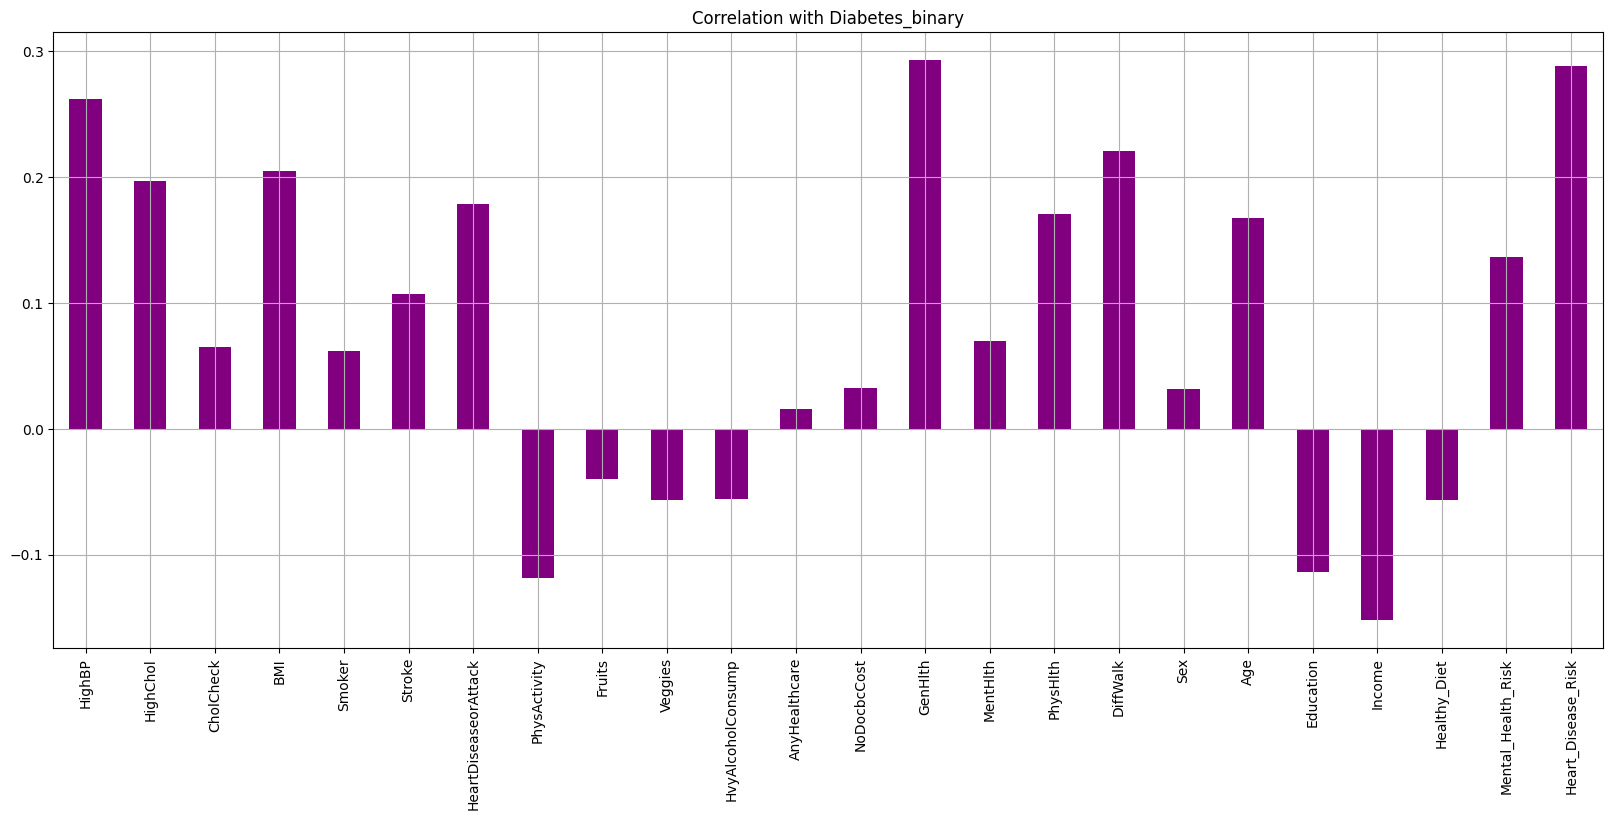

In [63]:
# Filter numeric columns only from X
X_numeric = X.select_dtypes(include=[np.number])

# Compute correlation with y
X_numeric.corrwith(y['Diabetes_binary']).plot(kind='bar', grid=True, figsize=(20, 8),
                                              title="Correlation with Diabetes_binary", color="Purple")


#### Gaussian distribution

In [ ]:

def normal_probability_plot(data, col):
    """
    Generates a normal probability plot for the given data.
    
    Parameters:
        data (array-like): The data for which to generate the plot.
        
    Returns:
        None
    """
    # Generate a probability plot
    stats.probplot(data, dist="norm", plot=plt)
    plt.title("Normal Probability Plot for "+ col)
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.show()

### Correlation matrix

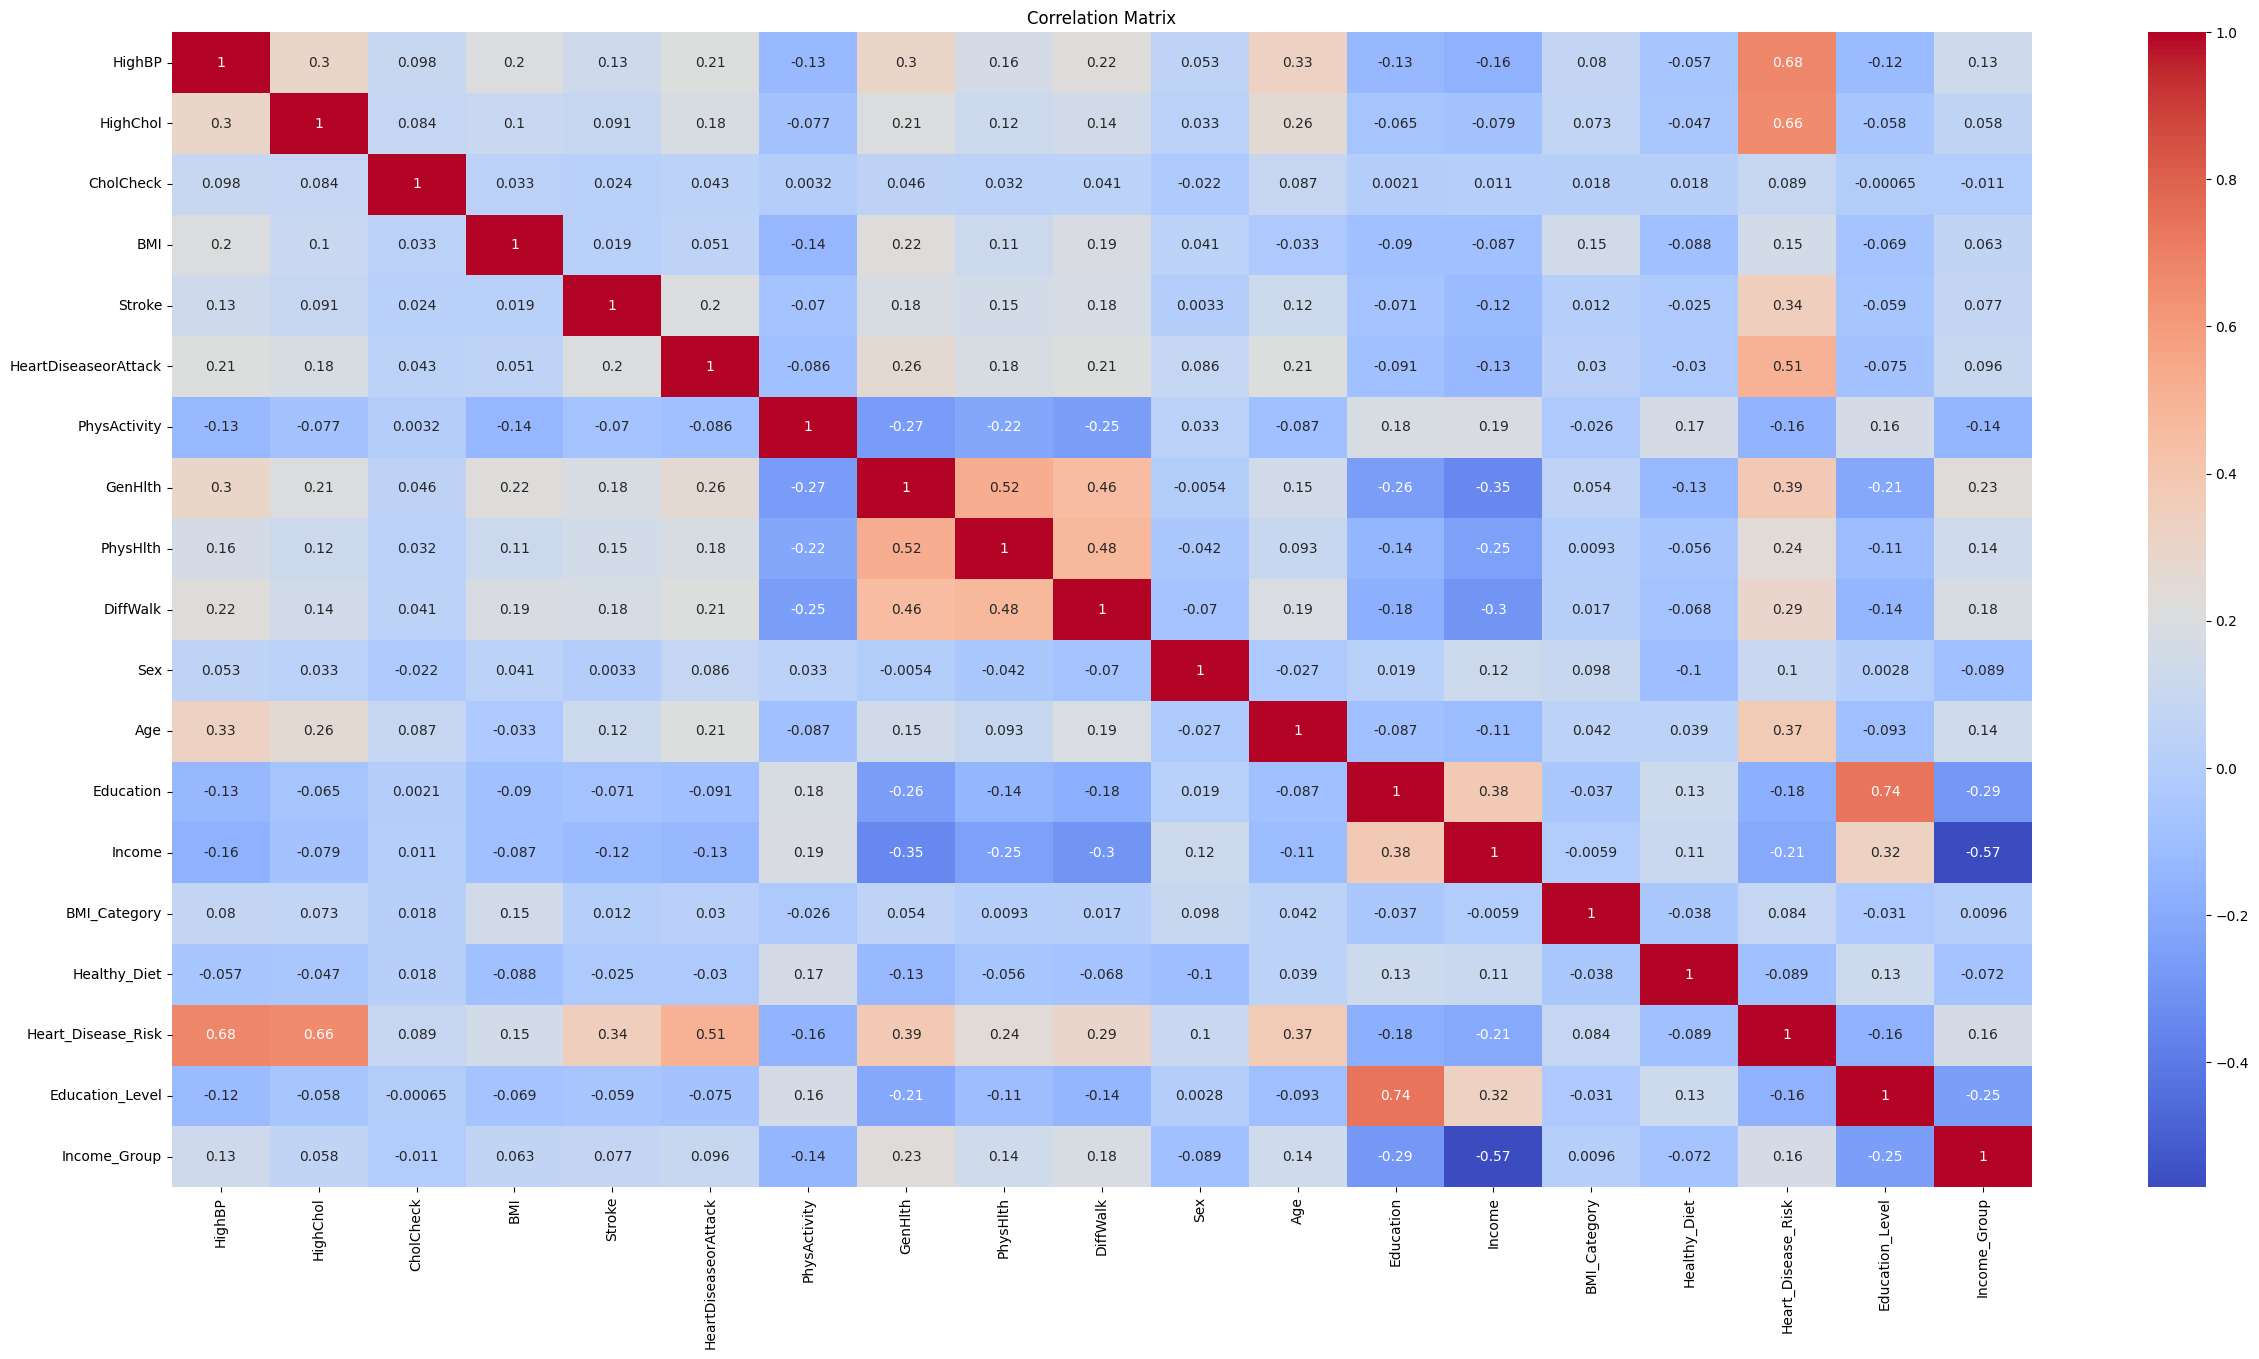

In [80]:
#Correlation matrix
corr = X.corr()
plt.figure(figsize=(30, 15))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Process the data and Split validation set and train set

In [53]:
from training import *
is_equal_classes = False
# Look for multicollinearity between the features and remove the features that are unnecessary
# we already know the age so age_group is not needed
columnsToDrop = ['Age_Group', 'MentHlth', 'HvyAlcoholConsump', 'NoDocbcCost', 'Smoker', 'Fruits', 'Veggies', 'Mental_Health_Risk' , 'AnyHealthcare' ] #'Heart_Disease_Risk', 'Income', 'Education'
X = X.drop(columns=columnsToDrop)
X = feature_encoding(X)

X_testing = X_testing.drop(columns=columnsToDrop)
X_testing = feature_encoding(X_testing)

# Basic splits of the data
X_train, X_validation, y_train, y_validation =  data_splits(X, y) #   split data
is_equal_classes = False
X_train_scaled, X_validation_scaled, X_testing_Scaled = normalize_features(X_train, X_validation, X_testing) #   normalize data

In [ ]:
# # Equal classes splits of the data
# X_train, X_validation, y_train, y_validation =  data_splits_equal_classes(X, y) #   split data into equal classes. Meaning there is as many diabetes as non diabetes. But we remove some data
# is_equal_classes = True
# X_train_scaled, X_validation_scaled, X_testing_Scaled = normalize_features(X_train, X_validation, X_testing) #   normalize data

### Training

In [6]:
import numpy as np
from sklearn.utils import gen_batches
def predict_in_batches(cls, X, batch_size=100):
    """
    Make predictions for the input data in batches.
    
    Parameters:
        cls (object): The trained classifier model.
        X (array-like): The input data to make predictions for.
        batch_size (int): The size of each batch.
        
    Returns:
        array-like: The predictions for the input data.
    """
    predictions = []
    
    # Generate batches and make predictions for each batch
    for batch in gen_batches(len(X), batch_size):
        batch_predictions = cls.predict(X[batch])
        predictions.append(batch_predictions)
    
    # Concatenate all batch predictions into a single array
    predictions = np.concatenate(predictions, axis=0)
    return predictions

In [7]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def perform_grid_search(model, X_train_scaled, y_train, params):
    print("Performing grid search for ", model)
    # Define the cross-validation strategy
    strat_kfold = StratifiedKFold(n_splits=10) # TODO

    # Grid search for the model 
    #"f1_macro": Calculates F1-score per class and takes the average, treating all classes equally.
    #"f1_weighted": Calculates F1-score per class and takes a weighted average, considering class imbalance.
    grid_search = GridSearchCV(model, params, scoring='f1', cv=strat_kfold, n_jobs=10) # n_jobs=10 uses 10 parallel processes. Speeds up the process 


    if isinstance(model, RandomForestClassifier) or isinstance(model, SVC):
        grid_search.fit(X_train_scaled, y_train.values.ravel())
    else:
        grid_search.fit(X_train, y_train)
    best_param = grid_search.best_params_
    best_score = grid_search.best_score_ 
    print("Best parameters are:", best_param)
    print("Best score is:", best_score)

    # Return the fitted grid search objects
    # return grid_search, best_param, best_score

In [8]:
def model_training(model, X_train_scaled, y_train, X_validation_scaled, y_validation):
    model.fit(X_train_scaled, y_train)
    y_validation_pred = model.predict(X_validation_scaled)
    validation_f1 = f1_score(y_validation, y_validation_pred)
    print("Validation f1 score:", validation_f1)
    print(classification_report(y_validation, y_validation_pred))

In [9]:
def classification_summary(y_train, y_train_pred, y_validation, y_validation_pred):
    train_f1 = f1_score(y_train, y_train_pred) 
    validation_f1 = f1_score(y_validation, y_validation_pred) 
    print("Train f1 score:", train_f1)

    print("Validation f1 score:", validation_f1)
    print("\nTraining Set Classification Report:")

    print(classification_report(y_train, y_train_pred))

    print("Training Set Confusion Matrix:")

    print(confusion_matrix(y_train, y_train_pred))

    print("\nValidation Set Classification Report:")

    print(classification_report(y_validation, y_validation_pred))

    print("Validation Set Confusion Matrix:")

    print(confusion_matrix(y_validation, y_validation_pred))

In [10]:
def classification_summary_one( y_validation, y_validation_pred):
    validation_f1 = f1_score(y_validation, y_validation_pred) 
    print("Validation f1 score:", validation_f1)
    print("\nValidation Set Classification Report:")

    print(classification_report(y_validation, y_validation_pred))

    print("Validation Set Confusion Matrix:")

    print(confusion_matrix(y_validation, y_validation_pred))

In [11]:
def kaggle_submission(model, X_testing_scaled, x_testing_id):
    y_pred = model.predict(X_testing_scaled)
    y_pred = pd.DataFrame({
        'index': x_testing_id , 
        'Diabetes_binary': y_pred,
    })

    # Save the predictions to a CSV file
    y_pred.to_csv(f'./{model}_y_pred.csv', index=False)

In [12]:
def submission_pred(model, X_testing_scaled):
    return model.predict(X_testing_scaled)


def submission_proba(model, X_testing_scaled):
    return model.predict_proba(X_testing_scaled)[:, 1]

## Models

### Random Forest

In [ ]:
############### TESTING ####################
from sklearn.ensemble import RandomForestClassifier


cls_randomforest = RandomForestClassifier(class_weight='balanced', 
                                          random_state=42, 
                                          max_depth=20, 
                                          max_leaf_nodes=200, 
                                          min_samples_leaf=20, n_estimators=500)

param_grid_random_forest = {
    'n_estimators': [10, 200, 300, 400, 500, 1000, 5000],
    'max_depth': [20, 30],
    'bootstrap': [True, False],
}
perform_grid_search(cls_randomforest, X_train_scaled, y_train, params= param_grid_random_forest)




In [92]:
if is_equal_classes:
    print('Equal classes')
    cls_randomforest = RandomForestClassifier(class_weight='balanced',
                                          random_state=42, 
                                          max_depth=20, 
                                          max_leaf_nodes=200, 
                                           n_estimators=1000) #min_samples_leaf=20
else:
    cls_randomforest = RandomForestClassifier( class_weight={0: 1, 1: 3}, # class_weight='balanced',
                                            random_state=0, 
                                            max_depth=20, 
                                            max_leaf_nodes=200, 
                                            n_estimators=1000) #min_samples_leaf=20

model_training(cls_randomforest, X_train_scaled, y_train, X_validation_scaled, y_validation)

c:\Users\sidne\anaconda3\envs\algo\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Validation f1 score: 0.461889548151529
              precision    recall  f1-score   support

           0       0.92      0.87      0.90     17460
           1       0.41      0.54      0.46      2835

    accuracy                           0.83     20295
   macro avg       0.66      0.70      0.68     20295
weighted avg       0.85      0.83      0.84     20295



In [ ]:
y_train_pred = predict_in_batches(cls_randomforest, X_train_scaled)
y_validation_pred = predict_in_batches(cls_randomforest, X_validation_scaled)

In [ ]:
classification_summary(y_train, y_train_pred, y_validation, y_validation_pred)

### Random Forest with PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=12)#n_components=2 #
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
cls_randomforest_pca = RandomForestClassifier(class_weight='balanced', random_state=42, max_depth=20, max_leaf_nodes=200, n_estimators=1000)
model_training(cls_randomforest_pca, X_train_pca, y_train, pca.transform(X_validation_scaled), y_validation)


### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

cls_decision_tree = DecisionTreeClassifier(max_depth=5)


param_grid_decision_tree = {
    'criterion': ['gini','entropy'],
    'max_depth': [10, 20, 50],
    'min_samples_leaf': [2, 3, 10],
    'max_leaf_nodes': [5, 10, 50]
}

perform_grid_search(cls_decision_tree, X_train_scaled, y_train, params=param_grid_decision_tree)


In [ ]:
cls_decision_tree = DecisionTreeClassifier(criterion='gini', class_weight={0: 1, 1: 3}, max_depth=10, min_samples_leaf=2, max_leaf_nodes=10)
model_training(cls_decision_tree, X_train_scaled, y_train, X_validation_scaled, y_validation)

### Decision Tree with Bagging

In [111]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

cls_decision_tree = DecisionTreeClassifier(class_weight={0: 1, 1: 3}, criterion='gini', max_depth=10, min_samples_leaf=2, max_leaf_nodes=10)
bagging_model = BaggingClassifier(estimator=cls_decision_tree, n_estimators=50, random_state=42)
model_training(bagging_model, X_train_scaled, y_train, X_validation_scaled, y_validation)

c:\Users\sidne\anaconda3\envs\algo\Lib\site-packages\sklearn\ensemble\_bagging.py:888: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation f1 score: 0.4362767070073211
              precision    recall  f1-score   support

           0       0.92      0.86      0.89     17460
           1       0.38      0.51      0.44      2835

    accuracy                           0.81     20295
   macro avg       0.65      0.69      0.66     20295
weighted avg       0.84      0.81      0.83     20295



### Decision Tree with Adaboosting

In [110]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Set up a decision stump as the weak learner
base_estimator = DecisionTreeClassifier(max_depth=1, class_weight={0: 1, 1: 3}, criterion='gini')  # Decision stump class_weight='balanced'

# Create an AdaBoost classifier using the decision tree as the base estimator
ada_boost = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=1.0, random_state=42)

# Assuming `model_training` is a function that trains and evaluates the model
model_training(ada_boost, X_train_scaled, y_train, X_validation_scaled, y_validation)


c:\Users\sidne\anaconda3\envs\algo\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\sidne\anaconda3\envs\algo\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Validation f1 score: 0.46190055898793764
              precision    recall  f1-score   support

           0       0.92      0.86      0.89     17460
           1       0.40      0.55      0.46      2835

    accuracy                           0.82     20295
   macro avg       0.66      0.71      0.68     20295
weighted avg       0.85      0.82      0.83     20295



### Logistic Regression

In [102]:
from sklearn.linear_model import LogisticRegression

In [ ]:
cls_logistic = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000, dual=False, C=5)
param_grid_logistic = {
    'max_iter':[1000, 2000, 3000],
    'tol': [1e-3, 1e-4, 1e-5],
    'C': [0.5, 1, 10],
}
perform_grid_search(cls_logistic, X_train_scaled, y_train, param_grid_logistic)

In [103]:
### Use best parameters to train the model
if is_equal_classes:
    print('Equal classes')
    cls_logistic = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000, dual=False, C=1, tol=1e-3)
else:
    cls_logistic = LogisticRegression(random_state=42, class_weight={0: 1, 1: 4}, max_iter=1000, dual=False, C=1, tol=1e-3)
model_training(cls_logistic, X_train_scaled, y_train, X_validation_scaled, y_validation)

Validation f1 score: 0.4622074434070853
              precision    recall  f1-score   support

           0       0.93      0.82      0.87     17460
           1       0.36      0.64      0.46      2835

    accuracy                           0.79     20295
   macro avg       0.65      0.73      0.67     20295
weighted avg       0.85      0.79      0.81     20295



c:\Users\sidne\anaconda3\envs\algo\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Logistic Regression with Adaboosting

In [ ]:
# Initialize logistic regression as the base estimator
cls_logistic_regiression = LogisticRegression(random_state=42, class_weight={0: 1, 1: 4}, max_iter=1000, dual=False, C=1, tol=1e-3)

# Create an AdaBoost classifier using logistic regression as the base estimator
ada_boost = AdaBoostClassifier(estimator=cls_logistic_regiression, n_estimators=50, learning_rate=1.0, random_state=42)

model_training(ada_boost, X_train_scaled, y_train, X_validation_scaled, y_validation)

### XGBClassifier

In [ ]:
from xgboost import XGBClassifier

In [ ]:
# Initialize the XGBoost classifier
# booster [default= gbtree ]
# Which booster to use. Can be gbtree, gblinear or dart; gbtree and dart use tree based models while gblinear uses linear functions.
xgb_model = XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='logloss') # binary:hinge

# Define the parameter grid
param_grid = {
    'eval_metric': ['error', 'logloss'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['error'],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 15]
}
perform_grid_search(xgb_model, X_train_scaled, y_train, param_grid)

In [ ]:
xgb_model = XGBClassifier(random_state=0, max_depth=10,  objective='binary:logistic', eval_metric='error', booster='gbtree', n_estimators=5000)
model_training(xgb_model, X_train_scaled, y_train, X_validation_scaled, y_validation)

### SVM

In [ ]:
cls_svm = SVC(class_weight='balanced', random_state=42, kernel='rbf', C=1)
param_grid_svm = {
    'kernel':['rbf', 'sigmoid'],
    'shrinking': [True],
    'C': [1, 10],
}
perform_grid_search(cls_svm, X_train_scaled, y_train, param_grid_svm)

In [ ]:
cls_svm = SVC(class_weight='balanced', random_state=42, kernel='rbf', C=1, shrinking=True)
model_training(cls_svm, X_train_scaled, y_train, X_validation_scaled, y_validation)

### K-NN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
param_grid_svm = {
    'weights':['distance', 'uniform', None],
    'leaf_size': [10, 30, 50],
}
cls_knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
perform_grid_search(cls_knn, X_train_scaled, y_train, param_grid_svm)

In [ ]:
cls_knn = KNeighborsClassifier(n_neighbors=5,  weights='distance', algorithm='auto', leaf_size= 10)
model_training(cls_knn, X_train_scaled, y_train, X_validation_scaled, y_validation)

### MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight

In [ ]:
cls_mlp = MLPClassifier( random_state=42, kernel='rbf', C=1)
param_grid_mlp = {
    'hidden_layer_sizes':[(100, 50), (50, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200, 300, 400],
    'solver': ['adam', 'sgd'],
    'shuffle': [True, False],
}
perform_grid_search(cls_mlp, X_train_scaled, y_train, param_grid_mlp)

In [ ]:
# sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
# cls_mlp = MLPClassifier(random_state=42, max_iter=1000, hidden_layer_sizes=(100, 50, 10, 1), activation='relu', solver='adam', alpha=0.001, learning_rate='adaptive', shuffle=True)
# cls_mlp.fit(X_train_scaled, y_train, sample_weight=sample_weights)
# y_validation_pred = cls_mlp.predict(X_validation_scaled)
# classification_summary_one(y_validation, y_validation_pred)


### Bagging

In [ ]:
# Validation set predictions

pred_array = []
for model in [cls_randomforest, cls_logistic, bagging_model, ada_boost]:#xgb_model
    pred_array.append(submission_pred(model, X_validation_scaled)) 

# Take the majority vote
pred_array = np.array(pred_array)
for i in range(len(pred_array[0])):
    if sum([pred[i] for pred in pred_array]) >= pred_array.shape[0] / 2:
        pred_array[0][i] = 1
    else:
        pred_array[0][i] = 0

classification_summary_one(y_validation, pred_array[0])

In [ ]:
# Testing set predictions

pred_array = []
for model in [cls_randomforest, cls_logistic, bagging_model, ada_boost]:#xgb_model
    pred_array.append(submission_pred(model, X_testing_Scaled))

# Take the majority vote
pred_array = np.array(pred_array)
for i in range(len(pred_array[0])):
    if sum([pred[i] for pred in pred_array]) >= pred_array.shape[0] / 2:
        pred_array[0][i] = 1
    else:
        pred_array[0][i] = 0

# Save the predictions to a CSV file
y_pred = pd.DataFrame({
    'index': x_testing_id , 
    'Diabetes_binary': pred_array[0],
})
y_pred.to_csv('./y_pred.csv', index=False)

In [ ]:
prob_array = []
for model in [cls_randomforest, cls_logistic, xgb_model, bagging_model, ada_boost]:
    prob_array.append(submission_proba(model, X_validation_scaled))

# Take most confident prediction
prob_array = np.array(prob_array)
for i in range(len(prob_array[0])):
    if sum([prob[i] for prob in prob_array]) >= 2.3: # best is either 1.3 or 1.4 considering 3 models
        prob_array[0][i] = 1
    else:
        prob_array[0][i] = 0
pred_array = prob_array[0].astype(int)
classification_summary_one(y_validation, pred_array)

### Hybrid Bagging

In [ ]:
pred_array = []
for model in [cls_randomforest, cls_logistic, xgb_model, bagging_model, ada_boost]:
    pred_array.append(submission_pred(model, X_validation_scaled))

prob_array = []
for model in [cls_randomforest, cls_logistic, xgb_model, bagging_model, ada_boost]:
    prob_array.append(submission_proba(model, X_validation_scaled))

# Take the majority vote
pred_array = np.array(pred_array)
for i in range(len(pred_array[0])):
    if sum([pred[i] for pred in pred_array]) >= pred_array.shape[0] / 2 or sum([prob[i] for prob in prob_array]) >= 3.0: # logistic has been train on a equal class dataset. This is an experiment
        pred_array[0][i] = 1
    else:
        pred_array[0][i] = 0

classification_summary_one(y_validation, pred_array[0])

### Bagging + PCA models

In [ ]:
pred_array = []

for model in [cls_randomforest, cls_logistic, bagging_model, ada_boost]:#xgb_model
    pred_array.append(submission_pred(model, X_validation_scaled))

for pca_model in [cls_randomforest_pca]:
    pred_array.append(submission_proba(pca_model, pca.transform(X_validation_scaled))) # 16 features. 12 components

# Take the majority vote
pred_array = np.array(pred_array)
for i in range(len(pred_array[0])):
    if sum([pred[i] for pred in pred_array]) >= pred_array.shape[0] / 2:
        pred_array[0][i] = 1
    else:
        pred_array[0][i] = 0

classification_summary_one(y_validation, pred_array[0])

## Neural Network

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F

# Ensure you have access to a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Calculate Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train['Diabetes_binary'].values.ravel())
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Step 2: Define the Custom Neural Network
class CustomNN(nn.Module):
    def __init__(self, input_size):
        super(CustomNN, self).__init__()
        # Adding more layers and neurons
        print('input size',input_size)
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)  # Binary classification output layer

        self.dropout = nn.Dropout(0.5)

        # Xavier uniform initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)
        nn.init.xavier_uniform_(self.output.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.output(x)
        return x

# Step 3: Initialize Model, Loss Function, and Optimizer


# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)

X_validation_tensor = torch.tensor(X_validation_scaled, dtype=torch.float32).to(device)
y_validation_tensor = torch.tensor(y_validation.values, dtype=torch.float32).to(device)

input_size = X_train_tensor.shape[1]  # Replace with the actual number of input features
model = CustomNN(input_size).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Use pos_weight for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.01)
# Step 4: Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train_tensor).squeeze()
    loss = criterion(outputs, y_train_tensor.squeeze())
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # Validation after each epoch
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_validation_tensor).squeeze()
            val_loss = criterion(val_outputs, y_validation_tensor.squeeze())
            val_preds = torch.round(torch.sigmoid(val_outputs))
            
            # Calculate F1 Score or other metrics
            # (Your F1 calculation code here using val_preds and y_validation_tensor)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Validation Loss: {val_loss.item()}")
classification_summary_one(y_validation, val_preds.cpu().numpy())

input size 19
Epoch [10/100], Loss: 0.6834769248962402, Validation Loss: 0.680522620677948
Epoch [20/100], Loss: 0.6717202663421631, Validation Loss: 0.6683007478713989
Epoch [30/100], Loss: 0.6655922532081604, Validation Loss: 0.6654670834541321
Epoch [40/100], Loss: 0.6638437509536743, Validation Loss: 0.6646057367324829
Epoch [50/100], Loss: 0.6620726585388184, Validation Loss: 0.6638550758361816
Epoch [60/100], Loss: 0.6605525016784668, Validation Loss: 0.6636506915092468
Epoch [70/100], Loss: 0.6590129137039185, Validation Loss: 0.6639540195465088
Epoch [80/100], Loss: 0.6581264734268188, Validation Loss: 0.6659994125366211
Epoch [90/100], Loss: 0.6565362215042114, Validation Loss: 0.6644055843353271
Epoch [100/100], Loss: 0.6534184217453003, Validation Loss: 0.6656954884529114
Validation f1 score: 0.4697986577181208

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88     17460
           1      

### Neural Network with normalization

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F
import numpy as np

# Ensure you have access to a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Calculate Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train['Diabetes_binary'].values.ravel())
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Step 2: Define the Custom Neural Network
class CustomNN(nn.Module):
    def __init__(self, input_size):
        super(CustomNN, self).__init__()
        # Adding more layers and neurons
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)  # Batch normalization
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)  # Batch normalization
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)   # Batch normalization
        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)  # Batch normalization
        self.fc5 = nn.Linear(32, 16)
        self.bn5 = nn.BatchNorm1d(16)  # Batch normalization
        self.output = nn.Linear(16, 1)  # Binary classification output layer

        # self.dropout = nn.Dropout(0.5)

        # Xavier uniform initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)
        nn.init.xavier_uniform_(self.output.weight)

    def forward(self, x):
        x = self.bn1(F.leaky_relu(self.fc1(x)))
        # x = self.dropout(x)
        x = self.bn2(F.leaky_relu(self.fc2(x)))
        # x = self.dropout(x)
        x = self.bn3(F.leaky_relu(self.fc3(x)))
        # x = self.dropout(x)
        x = self.bn4(F.leaky_relu(self.fc4(x)))
        # x = self.dropout(x)
        x = self.bn5(F.leaky_relu(self.fc5(x)))
        x = self.output(x)
        return x

# Step 3: Initialize Model, Loss Function, and Optimizer
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)

X_validation_tensor = torch.tensor(X_validation_scaled, dtype=torch.float32).to(device)
y_validation_tensor = torch.tensor(y_validation.values, dtype=torch.float32).to(device)

input_size = X_train_tensor.shape[1]  # Replace with the actual number of input features
model = CustomNN(input_size).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Use pos_weight for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 4: Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train_tensor).squeeze()
    loss = criterion(outputs, y_train_tensor.squeeze())
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # Validation after each epoch
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_validation_tensor).squeeze()
            val_loss = criterion(val_outputs, y_validation_tensor.squeeze())
            val_preds = torch.round(torch.sigmoid(val_outputs))
            
            # Calculate F1 Score or other metrics
            # (Your F1 calculation code here using val_preds and y_validation_tensor)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Validation Loss: {val_loss.item()}")
classification_summary_one(y_validation, val_preds.cpu().numpy())


Epoch [10/100], Loss: 0.7003148794174194, Validation Loss: 0.7274453639984131
Epoch [20/100], Loss: 0.6699306964874268, Validation Loss: 0.6739654541015625
Epoch [30/100], Loss: 0.6624476313591003, Validation Loss: 0.667755126953125
Epoch [40/100], Loss: 0.6587218046188354, Validation Loss: 0.667092502117157
Epoch [50/100], Loss: 0.6547770500183105, Validation Loss: 0.6697520017623901
Epoch [60/100], Loss: 0.6501547694206238, Validation Loss: 0.6740196943283081
Epoch [70/100], Loss: 0.6444652080535889, Validation Loss: 0.6938444972038269
Epoch [80/100], Loss: 0.6388710737228394, Validation Loss: 0.7137271761894226
Epoch [90/100], Loss: 0.6333040595054626, Validation Loss: 0.6867504119873047
Epoch [100/100], Loss: 0.6283716559410095, Validation Loss: 0.6942965984344482
Validation f1 score: 0.43889991494187697

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88     17460
           1       0.37      0.5

### Neural Network experiments

In [54]:
import torch

print("Torch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("Is CUDA available?", torch.cuda.is_available())
print("Available devices:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))


Torch version: 2.5.1+cu121
CUDA version: 12.1
Is CUDA available? True
Available devices: 1
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 4070 Ti


In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
import numpy as np
import torch.nn.functional as F

# Ensure you have access to a GPU if available
print("Is CUDA available?", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Calculate Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train['Diabetes_binary'].values.ravel())
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Step 2: Define the Custom Neural Network
class CustomNN(nn.Module):
    def __init__(self, input_size):
        super(CustomNN, self).__init__()
        self.layers = nn.ModuleList([
            nn.Linear(input_size, 512),
            nn.Linear(512, 512),
            nn.Linear(512, 256),
            nn.Linear(256, 256),
            nn.Linear(256, 128),
            nn.Linear(128, 128),
            nn.Linear(128, 64),
            nn.Linear(64, 64),
            nn.Linear(64, 32),
            nn.Linear(32, 16)
        ])
        self.output = nn.Linear(16, 1)  # Binary classification output layer
        self.dropout = nn.Dropout(0.1)

        # Xavier uniform initialization
        for layer in self.layers:
            if isinstance(layer, nn.Linear):  # Ensure it's a linear layer
                nn.init.xavier_uniform_(layer.weight)

        nn.init.xavier_uniform_(self.output.weight)

    def forward(self, x):
        for layer in self.layers:
            x = F.leaky_relu(layer(x))  # Apply ReLU after each linear layer
            x = self.dropout(x)  # Apply dropout after activation
        x = self.output(x)  # Final output layer (no activation here; handled by BCEWithLogitsLoss)
        return x

# Step 3: Initialize Model, Loss Function, and Optimizer
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)

X_validation_tensor = torch.tensor(X_validation_scaled, dtype=torch.float32).to(device)
y_validation_tensor = torch.tensor(y_validation.values, dtype=torch.float32).to(device)

input_size = X_train_tensor.shape[1]
model = CustomNN(input_size).to(device)
weights = torch.tensor(2.5, device='cuda:0')
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Use pos_weight for binary classification # 
optimizer = optim.NAdam(model.parameters(), lr=0.005)

# Step 4: Training Loop
num_epochs = 100  # Increased epochs
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train_tensor).squeeze()
    loss = criterion(outputs, y_train_tensor.squeeze())

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Validation after each epoch
    # Validation after each epoch
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_validation_tensor).squeeze()
            val_loss = criterion(val_outputs, y_validation_tensor.squeeze())
            val_preds = torch.round(torch.sigmoid(val_outputs))
            
            # Calculate F1 Score or other metrics
            # (Your F1 calculation code here using val_preds and y_validation_tensor)
        f1 = f1_score(y_validation_tensor.cpu().numpy(), val_preds.cpu().numpy())
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Validation Loss: {val_loss.item()},  F1 Score: {f1}")
classification_summary_one(y_validation, val_preds.cpu().numpy())


Is CUDA available? True
Epoch [10/100], Loss: 0.7625786066055298, Validation Loss: 0.7040237188339233,  F1 Score: 0.44649317306570196
Epoch [20/100], Loss: 0.6942477226257324, Validation Loss: 0.6732510924339294,  F1 Score: 0.4608139113633619
Epoch [30/100], Loss: 0.6948512196540833, Validation Loss: 0.6735683083534241,  F1 Score: 0.46711446963336134
Epoch [40/100], Loss: 0.685896635055542, Validation Loss: 0.6785972118377686,  F1 Score: 0.46107784431137727
Epoch [50/100], Loss: 0.6876114010810852, Validation Loss: 0.6765574216842651,  F1 Score: 0.46205982024458525
Epoch [60/100], Loss: 0.6855977773666382, Validation Loss: 0.6749851107597351,  F1 Score: 0.4634039444850256
Epoch [70/100], Loss: 0.6823128461837769, Validation Loss: 0.6728193163871765,  F1 Score: 0.4671699188149836
Epoch [80/100], Loss: 0.6821167469024658, Validation Loss: 0.6734593510627747,  F1 Score: 0.46833452466047176
Epoch [90/100], Loss: 0.6799544095993042, Validation Loss: 0.6744736433029175,  F1 Score: 0.46690099

### Neural Networks Expiriment with SMOTE

In [72]:
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
import numpy as np
import torch.nn.functional as F

# Ensure you have access to a GPU if available
print("Is CUDA available?", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train['Diabetes_binary'])

# Ensure resampled data is converted to NumPy arrays
X_train_resampled = np.array(X_train_resampled)
y_train_resampled = np.array(y_train_resampled)

# Update tensors for the resampled data
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.float32).to(device)


# Step 1: Calculate Class Weights (optional after SMOTE, since it balances the data)
# If you still want to calculate class weights:
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.array([0, 1]), 
    y=y_train_resampled
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Step 2: Define the Custom Neural Network (no change required here)
class CustomNN(nn.Module):
    def __init__(self, input_size):
        super(CustomNN, self).__init__()
        self.layers = nn.ModuleList([
            nn.Linear(input_size, 512),
            nn.Linear(512, 512),
            nn.Linear(512, 256),
            nn.Linear(256, 256),
            nn.Linear(256, 128),
            nn.Linear(128, 128),
            nn.Linear(128, 64),
            nn.Linear(64, 64),
            nn.Linear(64, 32),
            nn.Linear(32, 16)
        ])
        self.output = nn.Linear(16, 1)  # Binary classification output layer
        self.dropout = nn.Dropout(0.1)

        # Xavier uniform initialization
        for layer in self.layers:
            if isinstance(layer, nn.Linear):  # Ensure it's a linear layer
                nn.init.xavier_uniform_(layer.weight)

        nn.init.xavier_uniform_(self.output.weight)

    def forward(self, x):
        for layer in self.layers:
            x = F.leaky_relu(layer(x))  # Apply ReLU after each linear layer
            x = self.dropout(x)  # Apply dropout after activation
        x = self.output(x)  # Final output layer (no activation here; handled by BCEWithLogitsLoss)
        return x

# Step 3: Initialize Model, Loss Function, and Optimizer
X_validation_tensor = torch.tensor(X_validation_scaled, dtype=torch.float32).to(device)
y_validation_tensor = torch.tensor(y_validation.values, dtype=torch.float32).to(device)

input_size = X_train_tensor.shape[1]
model = CustomNN(input_size).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Use pos_weight for binary classification
optimizer = optim.NAdam(model.parameters(), lr=0.005)

# Step 4: Training Loop
num_epochs = 100  # Increased epochs
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train_tensor).squeeze()
    loss = criterion(outputs, y_train_tensor.squeeze())

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Validation after each epoch
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_validation_tensor).squeeze()
            val_loss = criterion(val_outputs, y_validation_tensor.squeeze())
            val_preds = torch.round(torch.sigmoid(val_outputs))

            # Calculate F1 Score
            f1 = f1_score(y_validation_tensor.cpu().numpy(), val_preds.cpu().numpy())
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Validation Loss: {val_loss.item()}, F1 Score: {f1}")

classification_summary_one(y_validation, val_preds.cpu().numpy())


Is CUDA available? True
Epoch [10/100], Loss: 0.6902785301208496, Validation Loss: 0.7225918173789978, F1 Score: 0.24545454545454545
Epoch [20/100], Loss: 0.6630594730377197, Validation Loss: 0.7021703720092773, F1 Score: 0.387502759991168
Epoch [30/100], Loss: 0.8684777617454529, Validation Loss: 0.709178626537323, F1 Score: 0.38005972130059723
Epoch [40/100], Loss: 0.7002319693565369, Validation Loss: 0.6443519592285156, F1 Score: 0.0
Epoch [50/100], Loss: 0.6615594029426575, Validation Loss: 0.6515459418296814, F1 Score: 0.3931014548607766
Epoch [60/100], Loss: 0.6710343360900879, Validation Loss: 0.66415935754776, F1 Score: 0.314161220043573
Epoch [70/100], Loss: 0.6498146057128906, Validation Loss: 0.660493791103363, F1 Score: 0.39960532807104093
Epoch [80/100], Loss: 0.6920618414878845, Validation Loss: 0.7185234427452087, F1 Score: 0.3174432175240147
Epoch [90/100], Loss: 0.6290499567985535, Validation Loss: 0.6539426445960999, F1 Score: 0.3847513812154696
Epoch [100/100], Loss:

In [14]:
import torch
from imblearn.over_sampling import SMOTE
import numpy as np

# Apply SMOTE on the training data (X_train and y_train)
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train['Diabetes_binary'].values)

# Convert resampled data to PyTorch tensors
X_train_resampled_tensor = torch.tensor(X_train_resampled, dtype=torch.float32).to(device)
y_train_resampled_tensor = torch.tensor(y_train_resampled, dtype=torch.float32).to(device)


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, size_average=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.size_average = size_average

    def forward(self, inputs, targets):
        # Apply sigmoid to the model's output to get probabilities
        inputs = torch.sigmoid(inputs)
        
        # Calculate cross-entropy
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')

        # Calculate focal loss components
        pt = torch.exp(-BCE_loss)  # pt = probability of correct class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        # Return the average loss
        if self.size_average:
            return torch.mean(focal_loss)
        else:
            return torch.sum(focal_loss)

# Use FocalLoss in the training loop:
focal_loss = FocalLoss(alpha=0.25, gamma=2).to(device)
# Initialize FocalLoss in place of BCEWithLogitsLoss
criterion = FocalLoss(alpha=0.25, gamma=2).to(device)

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train_resampled_tensor).squeeze()
    loss = criterion(outputs, y_train_resampled_tensor.squeeze())

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Validation after each epoch
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_validation_tensor).squeeze()
            val_loss = criterion(val_outputs, y_validation_tensor.squeeze())
            val_preds = torch.round(torch.sigmoid(val_outputs))

            # Calculate F1 Score or other metrics
            classification_summary_one(y_validation, val_preds)


Validation f1 score: 0.44204115917681647

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.74      0.83     17460
           1       0.31      0.74      0.44      2835

    accuracy                           0.74     20295
   macro avg       0.63      0.74      0.64     20295
weighted avg       0.86      0.74      0.77     20295

Validation Set Confusion Matrix:
[[12876  4584]
 [  730  2105]]
Validation f1 score: 0.45299989031479654

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.76      0.84     17460
           1       0.33      0.73      0.45      2835

    accuracy                           0.75     20295
   macro avg       0.64      0.74      0.65     20295
weighted avg       0.86      0.75      0.79     20295

Validation Set Confusion Matrix:
[[13243  4217]
 [  770  2065]]
Validation f1 score: 0.4395802098950525

Validation Set Cl

In [59]:
import torch

# Ensure that X_testing_Scaled is a tensor
X_testing_Scaled_tensor = torch.tensor(X_testing_Scaled, dtype=torch.float32).to(device)

# Set the model to evaluation mode
model.eval()

# No gradient calculation needed during inference
with torch.no_grad():
    # Get the model's predictions
    predictions = model(X_testing_Scaled_tensor).squeeze()  # Squeeze to remove any extra dimensions

    # Apply sigmoid activation function for binary classification
    predictions = torch.sigmoid(predictions)

    # Convert the probabilities to binary predictions (0 or 1)
    predictions_binary = torch.round(predictions)


# If you want to convert predictions back to a NumPy array for easier use:
predictions_binary = predictions_binary.cpu().numpy()

# Now you have predictions for the test data (0 or 1)
y_pred_nn = pd.DataFrame({
    'index': x_testing_id , 
    'Diabetes_binary': predictions_binary,
})
y_pred_nn.to_csv('./y_pred_nn.csv', index=False)

### Difference between Random forest and NN

In [91]:
y_pred = submission_pred(cls_randomforest, X_testing_Scaled)
y_pred = pd.DataFrame({
    'index': x_testing_id , 
    'Diabetes_binary': y_pred,
})
# Reset indices to make sure both DataFrames are aligned
y_pred_nn = y_pred_nn.reset_index(drop=True)
y_pred = y_pred.reset_index(drop=True)

# Now you can compare the predictions without worrying about index misalignment
diff_counter = 0
for index in range(len(y_pred_nn)):
    if y_pred_nn.loc[index, 'Diabetes_binary'] != y_pred.loc[index, 'Diabetes_binary']:
        diff_counter += 1

print('Number of differences:', diff_counter)



Number of differences: 2775


In [114]:
# Validation set predictions
X_testing_Scaled_tensor = torch.tensor(X_validation_scaled, dtype=torch.float32).to(device)

# Set the model to evaluation mode
model.eval()

# No gradient calculation needed during inference
with torch.no_grad():
    # Get the model's predictions
    predictions = model(X_testing_Scaled_tensor).squeeze()  # Squeeze to remove any extra dimensions

    # Apply sigmoid activation function for binary classification
    predictions = torch.sigmoid(predictions)

    # Convert the probabilities to binary predictions (0 or 1)
    predictions_binary = torch.round(predictions)


# If you want to convert predictions back to a NumPy array for easier use:
predictions_binary = predictions_binary.cpu().numpy()
################################################
pred_array = []
pred_array.append(submission_pred(cls_randomforest, X_validation_scaled))
pred_array.append(submission_pred(cls_logistic, X_validation_scaled))
# pred_array.append(submission_pred(ada_boost, X_validation_scaled))
pred_array.append(predictions_binary)

# Take the majority vote
pred_array = np.array(pred_array)
for i in range(len(pred_array[0])):
    if sum([pred[i] for pred in pred_array]) >= pred_array.shape[0] / 2:
        pred_array[0][i] = 1
    else:
        pred_array[0][i] = 0

classification_summary_one(y_validation, pred_array[0])

Validation f1 score: 0.46843575418994415

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89     17460
           1       0.39      0.59      0.47      2835

    accuracy                           0.81     20295
   macro avg       0.66      0.72      0.68     20295
weighted avg       0.85      0.81      0.83     20295

Validation Set Confusion Matrix:
[[14812  2648]
 [ 1158  1677]]
